In [1]:
import sys, os
sys.path.append('../../PyCOMPLETE/PyHEADTAIL')

from tqdm import tqdm
import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
%matplotlib notebook

from LHC import LHC
from PyHEADTAIL.impedances.wakes import WakeTable, WakeField
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.particles.slicing import UniformChargeSlicer
import scipy.io as sio


PyHEADTAIL v1.16.0


# Simulations with initial kick

In [2]:


Q_x = 62.309997537915
Q_y = 60.3199891814201
Q_s = 0.0020443
n_turns = 5000


def get_nonlinear_params(chroma, i_oct, p0=6.5e12*e/c):
    '''Arguments:
        - chroma: first-order chromaticity Q'_{x,y}, identical
          for both transverse planes
        - i_oct: octupole current in A (positive i_oct means
          LOF = i_oct > 0 and LOD = -i_oct < 0)
    '''
    # factor 2p0 is PyHEADTAIL's convention for d/dJx instead of
    # MAD-X's convention of d/d(2Jx)
    app_x = 2 * p0 * 27380.10941 * i_oct / 100.
    app_y = 2 * p0 * 28875.03442 * i_oct / 100.
    app_xy = 2 * p0 * -21766.48714 * i_oct / 100.
    Qpp_x = 4889.00298 * i_oct / 100.
    Qpp_y = -2323.147896 * i_oct / 100.
    return {
        'app_x': app_x,
        'app_y': app_y,
        'app_xy': app_xy,
        'Qp_x': [chroma,],# Qpp_x],
        'Qp_y': [chroma,],# Qpp_y],
        # second-order chroma commented out above!
    }


In [27]:
def py_ht_wake_sim(n_macroparticles, n_slices, wakefile, components_wake_input=None, add_wake=True, add_damper=True,
                   damping_rate=1000, n_turns_wake=1):
    

    C = 26658.883
    R = C / (2.*np.pi)

    alpha_x = 0.
    alpha_y = 0.
    beta_x = 66.0064
    beta_y = 71.5376
    alpha_0 = [0.0003225]

    machine_configuration = '2022_collimation'

    chroma = 0
    i_oct = 0

    machine = LHC(n_segments=1,
                  machine_configuration=machine_configuration,
                  **get_nonlinear_params(chroma=chroma, i_oct=i_oct))

    
    epsn_x = 3.e-6 # normalised horizontal emittance
    epsn_y = 3.e-6 # normalised vertical emittance
    sigma_z = 1.2e-9 * machine.beta*c/4. # RMS bunch length in meters
    intensity = 1.1e11

    bunch = machine.generate_6D_Gaussian_bunch_matched(
            n_macroparticles, intensity, epsn_x, epsn_y, sigma_z=sigma_z)

    slicer_for_wakefields = UniformChargeSlicer(
            n_slices, z_cuts=(-8*sigma_z, 8*sigma_z))

    data_wake = np.genfromtxt(wakefile + '.dat')
    
    components_wake = ['time', 'dipole_x', 'dipole_y',
                       'quadrupole_x', 'quadrupole_y',
                       'dipole_xy', 'dipole_yx']
    
    if components_wake_input is None: 
        components_wake_input = components_wake.copy()
    
    inds_wake = []
    
    for i, comp_inp in enumerate(components_wake_input):
            for comp in components_wake:
                if comp_inp == comp:
                    inds_wake.append(i)
                
    print(inds_wake)
    
    data_wake = data_wake[:,inds_wake]
    components_wake = np.array(components_wake)[inds_wake]
    
    np.savetxt(wakefile+"_user.dat", data_wake, delimiter='\t', fmt='%15.10e' ,newline='\n')

    wake_table = WakeTable(wakefile+"_user.dat",
                            components_wake, n_turns_wake=n_turns_wake)

    os.system('rm '+wakefile+ '_user.dat')
    
    wake_field = WakeField(slicer_for_wakefields, wake_table)

    # create transverse feedback instance
    damper = TransverseDamper(damping_rate, damping_rate)
    bunch.xp -= bunch.mean_xp()
    bunch.yp -= bunch.mean_yp()
    bunch.x -= bunch.mean_x() - 1e-4
    bunch.y -= bunch.mean_y() - 1e-4
    
    if add_damper:
        machine.one_turn_map.append(damper)
    if add_wake:
        machine.one_turn_map.append(wake_field)

    # prepare empty arrays to record transverse moments
    x = np.zeros(n_turns)
    xp = np.zeros_like(x)
    y = np.zeros_like(x)
    yp = np.zeros_like(x)
    t = np.arange(n_turns)
    # actual tracking
    for i in tqdm(t):
        for m in machine.one_turn_map:
            m.track(bunch)
            x[i] = bunch.mean_x()
            xp[i] = bunch.mean_xp()
            y[i] = bunch.mean_y()
            yp[i] = bunch.mean_yp()

    # evaluation of dipolar bunch moments
    j_x = np.sqrt(x**2 + (beta_x * xp)**2)
    exponent_x, amplitude_x = np.polyfit(t, np.log(2 * j_x), 1)

    j_y = np.sqrt(y**2 + (beta_y * yp)**2)
    exponent_y, amplitude_y = np.polyfit(t, np.log(2 * j_y), 1)

    print ('Horizontal reconstructed damping time: {:.3f} turns'.format(1/exponent_x))
    print ('Vertical reconstructed damping time: {:.3f} turns'.format(1/exponent_y))

    return x, y, xp, yp, machine

In [4]:
def plot_beam_position(x, y):
    plt.figure()
    t = np.arange(len(x))
    plt.plot(t, x, label='horizontal dipolar moment', alpha=0.8)
    plt.plot(t, y, label='vertical dipolar moment', alpha=0.8)
    plt.legend(loc=0);
    plt.xlabel('Turns')
    plt.ylabel('Centroid motion [m]')
    plt.legend(loc=4)
    #plt.yticks([]);

In [6]:
sys.path.append('../../PyCOMPLETE')
from PySUSSIX import Sussix

def calc_sussix_spec(x, xp, y, yp, q_x, q_y, n_lines=1):
    # Initialise Sussix object
    SX = Sussix()
    SX.sussix_inp(nt1=1, nt2=len(x), idam=2, ir=0, tunex=q_x, tuney=q_y)

    SX.sussix(x, xp,
              y, yp,
              # this line is not used by sussix:
              x, xp)

    os.remove('sussix.inp')

    return SX.ox[:n_lines], SX.oy[:n_lines]

def compute_tune_windows(x, xp, y, yp, machine, Q_window_size = 400, window_staggering = 50, n_turns_max=5000):
    spec_x, spec_y = calc_sussix_spec(x, xp, y, yp, machine.Q_x%1, machine.Q_y%1)
    print ('Horizontal fractional tune: {:.3f} vs. reconstructed {:.3f}'.format(machine.Q_x%1, spec_x[0]))
    print ('Vertical fractional tune: {:.3f} vs. reconstructed {:.3f}'.format(machine.Q_y%1, spec_y[0]))

    
    n_int = 0
    Qx = []
    Qy = []
    while n_int*window_staggering+Q_window_size<n_turns_max:
        n_init = n_int*window_staggering
        n_end = n_int*window_staggering+Q_window_size
        spec_x, spec_y = calc_sussix_spec(x[n_init:n_end], xp[n_init:n_end], y[n_init:n_end], yp[n_init:n_end], machine.Q_x%1, machine.Q_y%1)
        Qx.append(spec_x)
        Qy.append(spec_y)
        n_int+=1
    
    return np.array(Qx)[:,0], np.array(Qy)[:,0]

def plot_tune_windows(Qx, Qy, machine_Q_x, machine_Q_y):
    plt.figure()
    plt.plot(np.ones_like(Qx)*(machine_Q_x%1), 'r--', label='Machine Qx')
    plt.plot(Qx, 'r', label='Measured Qx')
    plt.plot(np.ones_like(Qx)*np.mean(Qx[:3000]), 'r-.', label='Mean Measured Qx')
    print('Mean Qx during transient: {}'.format(np.mean(Qx[:3000])))
    plt.plot(np.ones_like(Qy)*(machine_Q_y%1), 'b--', label='Machine Qy')
    plt.plot(Qy, 'b', label='Measured Qy')
    plt.plot(np.ones_like(Qy)*np.mean(Qy[:3000]), 'b-.', label='Mean Measured Qy')
    print('Mean Qy during transient: {}'.format(np.mean(Qy[:3000])))
    plt.legend()

## Baseline

In [7]:
# Basic parameters.
n_sl = 500
n_mps = 1000000
wakefile = 'wakes/wakeforhdtl_PyZbase_Allthemachine_6800GeV_B1_2022_TeleIndex1_baseline'
x_baseline, y_baseline, xp_baseline, yp_baseline, machine = py_ht_wake_sim(n_mps, n_sl, wakefile=wakefile)

Synchrotron init. From kwargs: app_x = 0.0
Synchrotron init. From kwargs: app_y = 0.0
Synchrotron init. From kwargs: app_xy = -0.0
Synchrotron init. From kwargs: Qp_x = [0 ...]
Synchrotron init. From kwargs: Qp_y = [0 ...]
*** Maximum RMS bunch length 0.11789515101464539m.
... distance to target bunch length: -8.9938e-02
... distance to target bunch length: 2.4700e-02
... distance to target bunch length: 2.2562e-02
... distance to target bunch length: 4.1287e-03
... distance to target bunch length: -8.3050e-03
... distance to target bunch length: 6.8811e-04
... distance to target bunch length: -1.6257e-05
... distance to target bunch length: 2.5724e-07
... distance to target bunch length: -3.3327e-08
--> Bunch length: 0.08993770321674203
--> Emittance: 2.297587233294769
[0, 1, 2, 3, 4, 5, 6]
dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
dipole_xy Assuming ultrarelativistic wake.
dipole_yx Assuming ultrarelativistic wake.
quadrupole_x Assuming ultra

100%|██████████████████████████████████████████████| 5000/5000 [1:05:30<00:00,  1.27it/s]


Horizontal reconstructed damping time: -1746.064 turns
Vertical reconstructed damping time: -1810.611 turns


In [8]:
Qx_baseline, Qy_baseline = compute_tune_windows(x_baseline, xp_baseline,
                                                y_baseline, yp_baseline, machine)

Horizontal fractional tune: 0.310 vs. reconstructed 0.310
Vertical fractional tune: 0.320 vs. reconstructed 0.320


In [18]:

dict_x_baseline = {
    'x': x_baseline,
    'y': y_baseline,
    'xp': xp_baseline,
    'yp': yp_baseline,
    'Qx': Qx_baseline,
    'Qy': Qy_baseline
}


sio.savemat('res_baseline.mat', dict_x_baseline)

<IPython.core.display.Javascript object>


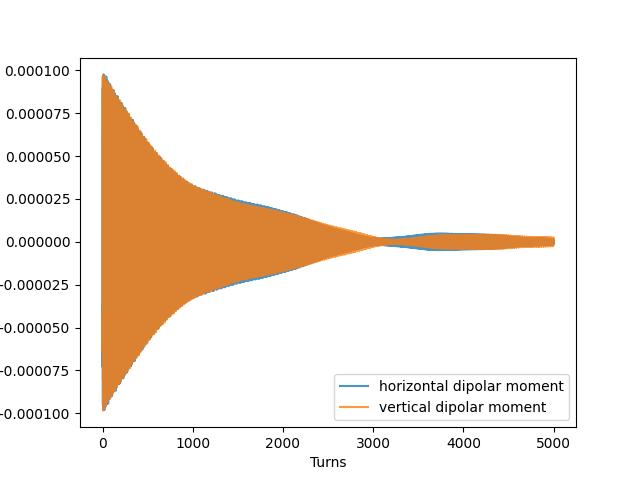

<IPython.core.display.Javascript object>


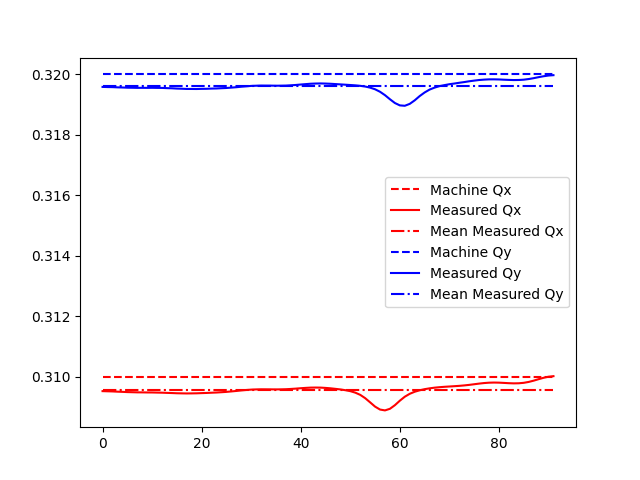

Mean Qx during transient: 0.30955050577178367
Mean Qy during transient: 0.31959284367881424


In [25]:
dict_x_baseline = sio.loadmat('res_baseline.mat', squeeze_me=True)

x_baseline = dict_x_baseline['x']
y_baseline = dict_x_baseline['y']
xp_baseline = dict_x_baseline['xp']
yp_baseline = dict_x_baseline['yp']
Qx_baseline = dict_x_baseline['Qx']
Qy_baseline = dict_x_baseline['Qy']

plot_beam_position(x_baseline, y_baseline)
plot_tune_windows(Qx_baseline, Qy_baseline, Q_x, Q_y)

In [21]:
%matplotlib notebook
n_init = 0
n_end = 3000

spec_x_baseline, spec_y_baseline = calc_sussix_spec(x_baseline[n_init:n_end], xp_baseline[n_init:n_end], y_baseline[n_init:n_end], yp_baseline[n_init:n_end], Q_x%1, Q_y%1)
print(-spec_x_baseline + spec_x_optics3)

[-1.87567662e-05]


In [ ]:
dict_x_baseline_G200 = sio.loadmat('res_baseline_G200.mat', squeeze_me=True)

x_baseline_G200 = dict_x_baseline['x']
y_baseline_G200 = dict_x_baseline['y']
xp_baseline_G200 = dict_x_baseline['xp']
yp_baseline_G200 = dict_x_baseline['yp']
Qx_baseline_G200 = dict_x_baseline['Qx']
Qy_baseline_G200 = dict_x_baseline['Qy']

plot_beam_position(x_baseline_G200, y_baseline_G200)
plot_tune_windows(Qx_baseline_G200, Qy_baseline_G200, Q_x, Q_y)

## Baseline G=200

In [ ]:
# Basic parameters.
n_sl = 500
n_mps = 1000000
wakefile = 'wakes/wakeforhdtl_PyZbase_Allthemachine_6800GeV_B1_2022_TeleIndex1_baseline'
x_baseline_G200, y_baseline_G200, xp_baseline_G200, yp_baseline_G200, machine = py_ht_wake_sim(n_mps, n_sl, wakefile=wakefile, damping_rate=200)

Synchrotron init. From kwargs: app_x = 0.0
Synchrotron init. From kwargs: app_y = 0.0
Synchrotron init. From kwargs: app_xy = -0.0
Synchrotron init. From kwargs: Qp_x = [0 ...]
Synchrotron init. From kwargs: Qp_y = [0 ...]
*** Maximum RMS bunch length 0.11789515101464539m.
... distance to target bunch length: -8.9938e-02
... distance to target bunch length: 2.4700e-02
... distance to target bunch length: 2.2562e-02
... distance to target bunch length: 4.1287e-03
... distance to target bunch length: -8.3050e-03
... distance to target bunch length: 6.8811e-04
... distance to target bunch length: -1.6257e-05
... distance to target bunch length: 2.5724e-07
... distance to target bunch length: -3.3327e-08
--> Bunch length: 0.08993770321674203
--> Emittance: 2.297587233294769
[0, 1, 2, 3, 4, 5, 6]
dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
dipole_xy Assuming ultrarelativistic wake.
dipole_yx Assuming ultrarelativistic wake.
quadrupole_x Assuming ultra

 20%|█████████▋                                      | 1012/5000 [10:04<34:31,  1.93it/s]

In [ ]:
Qx_baseline_G200, Qy_baseline_G200 = compute_tune_windows(x_baseline_G200, xp_baseline_G200,
                                                y_baseline_G200, yp_baseline_G200, machine)

In [ ]:

dict_x_baseline_G200 = {
    'x': x_baseline_G200,
    'y': y_baseline_G200,
    'xp': xp_baseline_G200,
    'yp': yp_baseline_G200,
    'Qx': Qx_baseline_G200,
    'Qy': Qy_baseline_G200
}


sio.savemat('res_baseline_G200.mat', dict_x_baseline_G200)

In [ ]:
%matplotlib notebook
n_init = 0
n_end = 2048

spec_x_baseline, spec_y_baseline_G200 = calc_sussix_spec(x_baseline[n_init:n_end], xp_baseline[n_init:n_end], y_baseline[n_init:n_end], yp_baseline[n_init:n_end], Q_x%1, Q_y%1)
print(-spec_y_baseline+spec_y_baseline_G200)

## Optics 3

In [30]:
# Basic parameters.
n_sl = 500
n_mps = 1000000
wakefile = 'wakes/wakeforhdtl_PyZbase_Allthemachine_6800GeV_B1_2022_TeleIndex1_MD_IR7_optics3'
x_optics3, y_optics3, xp_optics3, yp_optics3, machine = py_ht_wake_sim(n_mps, n_sl, wakefile=wakefile)

Synchrotron init. From kwargs: app_x = 0.0
Synchrotron init. From kwargs: app_y = 0.0
Synchrotron init. From kwargs: app_xy = -0.0
Synchrotron init. From kwargs: Qp_x = [0 ...]
Synchrotron init. From kwargs: Qp_y = [0 ...]
*** Maximum RMS bunch length 0.11789515101464539m.
... distance to target bunch length: -8.9938e-02
... distance to target bunch length: 2.4700e-02
... distance to target bunch length: 2.2562e-02
... distance to target bunch length: 4.1287e-03
... distance to target bunch length: -8.3050e-03
... distance to target bunch length: 6.8811e-04
... distance to target bunch length: -1.6257e-05
... distance to target bunch length: 2.5724e-07
... distance to target bunch length: -3.3327e-08
--> Bunch length: 0.08993770321674203
--> Emittance: 2.297587233294769
[0, 1, 2, 3, 4, 5, 6]
dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
dipole_xy Assuming ultrarelativistic wake.
dipole_yx Assuming ultrarelativistic wake.
quadrupole_x Assuming ultra

100%|█████████████████████████████████████████████████████████████████████████| 5000/5000 [29:59<00:00,  2.78it/s]

Horizontal reconstructed damping time: -1218.836 turns
Vertical reconstructed damping time: -1150.584 turns


In [15]:
Qx_optics3, Qy_optics3 = compute_tune_windows(x_optics3, xp_optics3, y_optics3, yp_optics3, machine)

NameError: name 'xp_optics3' is not defined

In [34]:

dict_optics3 = {
    'x': x_optics3,
    'y': y_optics3,
    'xp': xp_optics3,
    'yp': yp_optics3,
    'Qx': Qx_optics3,
    'Qy': Qy_optics3
}


sio.savemat('res_optics3.mat', dict_optics3)

<IPython.core.display.Javascript object>


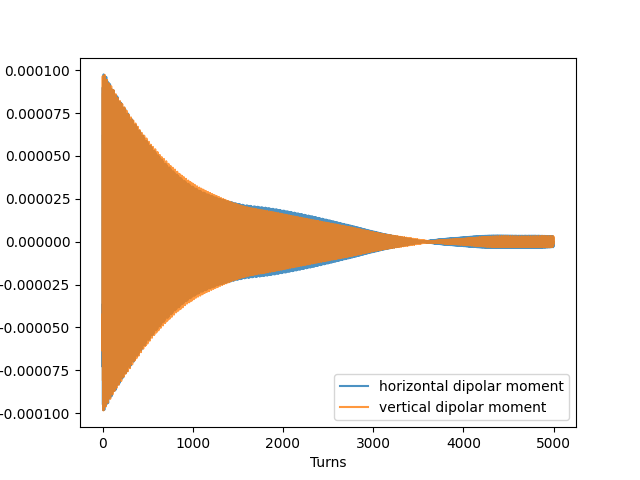

<IPython.core.display.Javascript object>


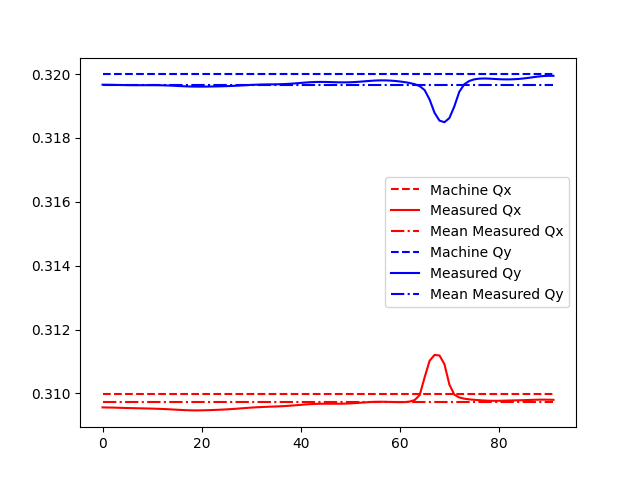

Mean Qx during transient: 0.30973041148148367
Mean Qy during transient: 0.31965843108518244


In [7]:
dict_optics3 = sio.loadmat('res_optics3.mat', squeeze_me=True)

x_optics3 = dict_optics3['x']
y_optics3 = dict_optics3['y']
xp_optics3 = dict_optics3['xp']
yp_optics3 = dict_optics3['yp']
Qx_optics3 = dict_optics3['Qx']
Qy_optics3 = dict_optics3['Qy']

plot_beam_position(x_optics3, y_optics3)
plot_tune_windows(Qx_optics3, Qy_optics3, Q_x, Q_y)

In [8]:
%matplotlib notebook
n_init = 0
n_end = 3000

spec_x_baseline, spec_y_baseline = calc_sussix_spec(x_baseline[n_init:n_end], xp_baseline[n_init:n_end], y_baseline[n_init:n_end], yp_baseline[n_init:n_end], Q_x%1, Q_y%1)
spec_x_optics3, spec_y_optics3 = calc_sussix_spec(x_optics3[n_init:n_end], xp_optics3[n_init:n_end], y_optics3[n_init:n_end], yp_optics3[n_init:n_end], Q_x%1, Q_y%1)
print(-spec_x_baseline + spec_x_optics3)

[3.89643125e-05]


## Optics 5

In [53]:
# Basic parameters.
n_sl = 500
n_mps = 1000000

wakefile = 'wakes/wakeforhdtl_PyZbase_Allthemachine_6800GeV_B1_2022_TeleIndex1_MD_IR7_optics5'
x_optics5, y_optics5, xp_optics5, yp_optics5, machine = py_ht_wake_sim(n_mps, n_sl, wakefile=wakefile)


Synchrotron init. From kwargs: app_x = 0.0
Synchrotron init. From kwargs: app_y = 0.0
Synchrotron init. From kwargs: app_xy = -0.0
Synchrotron init. From kwargs: Qp_x = [0 ...]
Synchrotron init. From kwargs: Qp_y = [0 ...]
*** Maximum RMS bunch length 0.11789515101464539m.
... distance to target bunch length: -8.9938e-02
... distance to target bunch length: 2.4700e-02
... distance to target bunch length: 2.2562e-02
... distance to target bunch length: 4.1287e-03
... distance to target bunch length: -8.3050e-03
... distance to target bunch length: 6.8811e-04
... distance to target bunch length: -1.6257e-05
... distance to target bunch length: 2.5724e-07
... distance to target bunch length: -3.3327e-08
--> Bunch length: 0.08993770321674203
--> Emittance: 2.297587233294769
[0, 1, 2, 3, 4, 5, 6]
dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
dipole_xy Assuming ultrarelativistic wake.
dipole_yx Assuming ultrarelativistic wake.
quadrupole_x Assuming ultra

100%|█████████████████████████████████████████████████████████████████████████| 5000/5000 [29:00<00:00,  2.87it/s]

Horizontal reconstructed damping time: -1252.488 turns
Vertical reconstructed damping time: -1160.054 turns


In [57]:
Qx, Qy = compute_tune_windows(x_optics5, xp_optics5, y_optics5, yp_optics5, machine)

Horizontal fractional tune: 0.310 vs. reconstructed 0.310
Vertical fractional tune: 0.320 vs. reconstructed 0.320


In [ ]:
dict_optics5 = {
    'x': x_optics5,
    'y': y_optics5,
    'xp': xp_optics5,
    'yp': yp_optics5,
    'Qx': Qx,
    'Qy': Qy
}


sio.savemat('res_optics5.mat', dict_optics5)


<IPython.core.display.Javascript object>


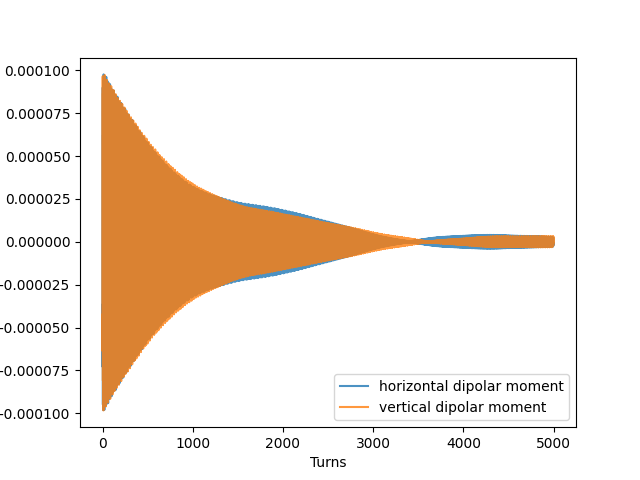

<IPython.core.display.Javascript object>


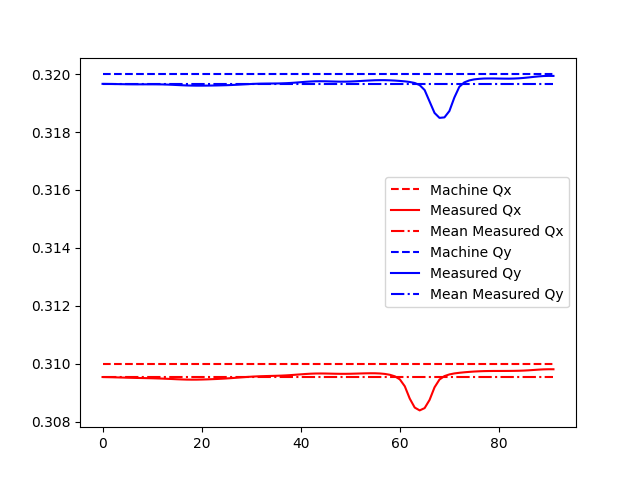

Mean Qx during transient: 0.3095409038934028
Mean Qy during transient: 0.31965627433030447


In [9]:
dict_optics5 = sio.loadmat('res_optics5.mat', squeeze_me=True)

x_optics5 = dict_optics5['x']
y_optics5 = dict_optics5['y']
xp_optics5 = dict_optics5['xp']
yp_optics5 = dict_optics5['yp']
Qx_optics5 = dict_optics5['Qx']
Qy_optics5 = dict_optics5['Qy']

plot_beam_position(x_optics5, y_optics5)
plot_tune_windows(Qx_optics5, Qy_optics5, Q_x, Q_y)

In [10]:
%matplotlib notebook
n_init = 0
n_end = 3000

spec_x_baseline, spec_y_baseline = calc_sussix_spec(x_baseline[n_init:n_end], xp_baseline[n_init:n_end], y_baseline[n_init:n_end], yp_baseline[n_init:n_end], Q_x%1, Q_y%1)
spec_x_optics5, spec_y_optics5 = calc_sussix_spec(x_optics5[n_init:n_end], xp_optics5[n_init:n_end], y_optics5[n_init:n_end], yp_optics5[n_init:n_end], Q_x%1, Q_y%1)
print(-spec_x_baseline + spec_x_optics5)

[1.82262905e-05]


## Optics 3 Asymmetric Collimators

In [63]:
# Basic parameters.
n_sl = 500
n_mps = 1000000
wakefile = 'wakes/wakeforhdtl_PyZbase_Allthemachine_6800GeV_B1_2022_TeleIndex1_MD_IR7_optics3_asymmetric'
x_optics3_asym, y_optics3_asym, xp_optics3_asym, yp_optics3_asym, machine = py_ht_wake_sim(n_mps, n_sl, wakefile=wakefile)

Synchrotron init. From kwargs: app_x = 0.0
Synchrotron init. From kwargs: app_y = 0.0
Synchrotron init. From kwargs: app_xy = -0.0
Synchrotron init. From kwargs: Qp_x = [0 ...]
Synchrotron init. From kwargs: Qp_y = [0 ...]
*** Maximum RMS bunch length 0.11789515101464539m.
... distance to target bunch length: -8.9938e-02
... distance to target bunch length: 2.4700e-02
... distance to target bunch length: 2.2562e-02
... distance to target bunch length: 4.1287e-03
... distance to target bunch length: -8.3050e-03
... distance to target bunch length: 6.8811e-04
... distance to target bunch length: -1.6257e-05
... distance to target bunch length: 2.5724e-07
... distance to target bunch length: -3.3327e-08
--> Bunch length: 0.08993770321674203
--> Emittance: 2.297587233294769
[0, 1, 2, 3, 4, 5, 6]
dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
dipole_xy Assuming ultrarelativistic wake.
dipole_yx Assuming ultrarelativistic wake.
quadrupole_x Assuming ultra

100%|█████████████████████████████████████████████████████████████████████████| 5000/5000 [29:25<00:00,  2.83it/s]

Horizontal reconstructed damping time: -1265.749 turns
Vertical reconstructed damping time: -1169.540 turns


In [64]:
Qx_optics3_asym, Qy_optics3_asym = compute_tune_windows(x_optics3_asym, xp_optics3_asym, y_optics3_asym, yp_optics3_asym, machine)

Horizontal fractional tune: 0.310 vs. reconstructed 0.310
Vertical fractional tune: 0.320 vs. reconstructed 0.320


In [65]:

dict_optics3_asym = {
    'x': x_optics3_asym,
    'y': y_optics3_asym,
    'xp': xp_optics3_asym,
    'yp': yp_optics3_asym,
    'Qx': Qx_optics3_asym,
    'Qy': Qy_optics3_asym
}


sio.savemat('res_optics3_asym.mat', dict_optics3_asym)

<IPython.core.display.Javascript object>


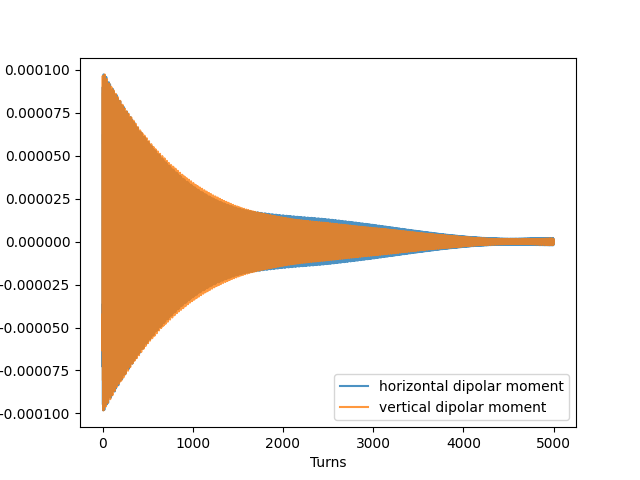

<IPython.core.display.Javascript object>


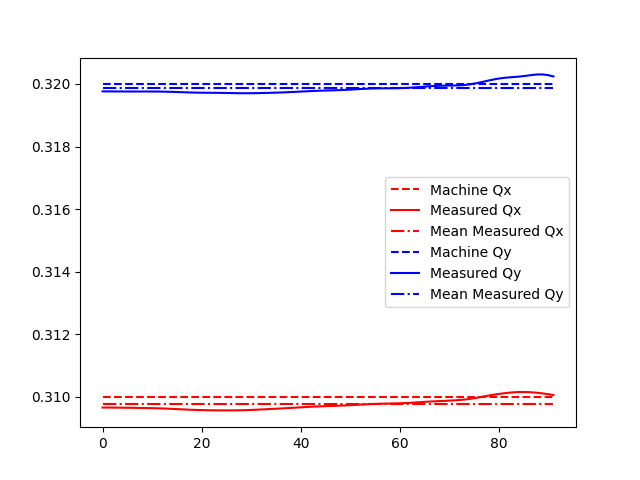

Mean Qx during transient: 0.3097655005284928
Mean Qy during transient: 0.31986813271480263


In [11]:
dict_optics3_asym = sio.loadmat('res_optics3_asym.mat', squeeze_me=True)

x_optics3_asym = dict_optics3_asym['x']
y_optics3_asym = dict_optics3_asym['y']
xp_optics3_asym = dict_optics3_asym['xp']
yp_optics3_asym = dict_optics3_asym['yp']
Qx_optics3_asym = dict_optics3_asym['Qx']
Qy_optics3_asym = dict_optics3_asym['Qy']

plot_beam_position(x_optics3_asym, y_optics3_asym)
plot_tune_windows(Qx_optics3_asym, Qy_optics3_asym, Q_x, Q_y)

In [12]:
%matplotlib notebook
n_init = 0
n_end = 3000

spec_x_baseline, spec_y_baseline = calc_sussix_spec(x_baseline[n_init:n_end], xp_baseline[n_init:n_end], y_baseline[n_init:n_end], yp_baseline[n_init:n_end], Q_x%1, Q_y%1)
spec_x_optics3_asym, spec_y_optics3_asym = calc_sussix_spec(x_optics3_asym[n_init:n_end], xp_optics3_asym[n_init:n_end], y_optics3_asym[n_init:n_end], yp_optics3_asym[n_init:n_end], Q_x%1, Q_y%1)
print(-spec_x_baseline + spec_x_optics3_asym)

[0.00011893]


## Complete Wake - Multiturn

In [23]:
# Basic parameters.
n_sl = 500
n_mps = 1000000
wakefile = 'wakes/wakeforhdtl_PyZbase_Allthemachine_6800GeV_B1_2022_TeleIndex1_MD_IR7_optics5_asymmetric'
x_optics5_asym, y_optics5_asym, xp_optics5_asym, yp_optics5_asym, machine = py_ht_wake_sim(n_mps, n_sl, wakefile=wakefile)


Synchrotron init. From kwargs: app_x = 0.0
Synchrotron init. From kwargs: app_y = 0.0
Synchrotron init. From kwargs: app_xy = -0.0
Synchrotron init. From kwargs: Qp_x = [0 ...]
Synchrotron init. From kwargs: Qp_y = [0 ...]
*** Maximum RMS bunch length 0.11789515101464539m.
... distance to target bunch length: -8.9938e-02
... distance to target bunch length: 2.4700e-02
... distance to target bunch length: 2.2562e-02
... distance to target bunch length: 4.1287e-03
... distance to target bunch length: -8.3050e-03
... distance to target bunch length: 6.8811e-04
... distance to target bunch length: -1.6257e-05
... distance to target bunch length: 2.5724e-07
... distance to target bunch length: -3.3327e-08
--> Bunch length: 0.08993770313589648
--> Emittance: 2.3327935372128716
[0, 1, 2, 3, 4, 5, 6]
dipole_x Assuming ultrarelativistic wake.
*** PyHEADTAIL WARNING! You use multiturn wakes. The stored SliceSet instances from previous turns are converted from z to dt according to the current tur

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:25:57<00:00,  1.03s/it]


Horizontal reconstructed damping time: -1222.823 turns
Vertical reconstructed damping time: -1277.767 turns


In [24]:
Qx_optics5_asym, Qy_optics5_asym = compute_tune_windows(x_optics5_asym, xp_optics5_asym, y_optics5_asym, yp_optics5_asym, machine)


Horizontal fractional tune: 0.310 vs. reconstructed 0.309
Vertical fractional tune: 0.320 vs. reconstructed 0.320


In [25]:

dict_optics5_asym = {
    'x': x_optics5_asym,
    'y': y_optics5_asym,
    'xp': xp_optics5_asym,
    'yp': yp_optics5_asym,
    'Qx': Qx_optics5_asym,
    'Qy': Qy_optics5_asym
}


sio.savemat('res_optics5_asym.mat', dict_optics5_asym)

<IPython.core.display.Javascript object>


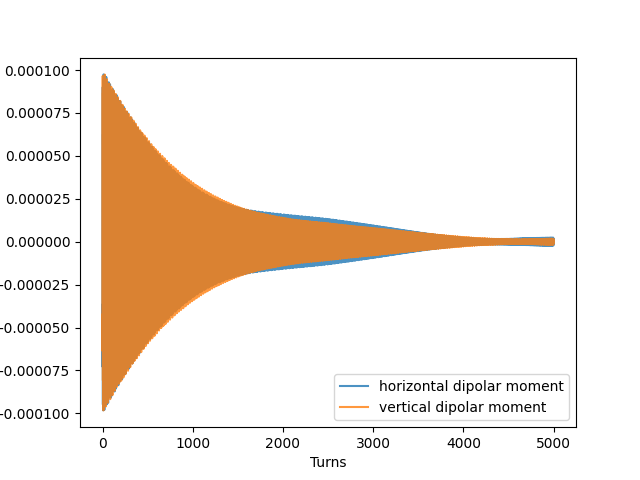

<IPython.core.display.Javascript object>


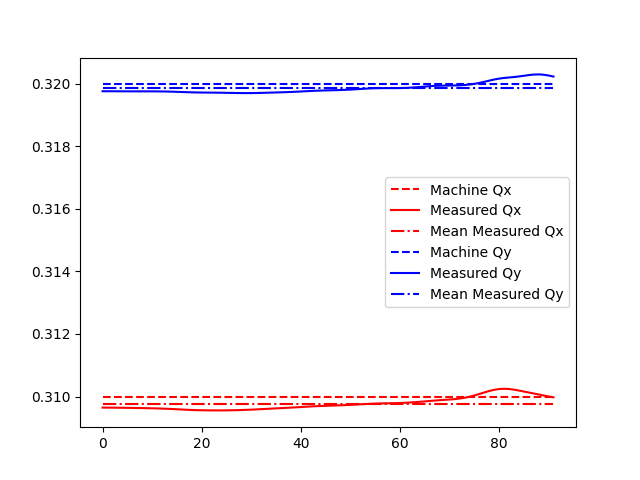

Mean Qx during transient: 0.3097724855894214
Mean Qy during transient: 0.3198647141078094


In [13]:
dict_optics5_asym = sio.loadmat('res_optics5_asym.mat', squeeze_me=True)

x_optics5_asym = dict_optics5_asym['x']
y_optics5_asym = dict_optics5_asym['y']
xp_optics5_asym = dict_optics5_asym['xp']
yp_optics5_asym = dict_optics5_asym['yp']
Qx_optics5_asym = dict_optics5_asym['Qx']
Qy_optics5_asym = dict_optics5_asym['Qy']

plot_beam_position(x_optics5_asym, y_optics5_asym)
plot_tune_windows(Qx_optics5_asym, Qy_optics5_asym, Q_x, Q_y)

In [14]:
%matplotlib notebook
n_init = 0
n_end = 3000

spec_x_baseline, spec_y_baseline = calc_sussix_spec(x_baseline[n_init:n_end], xp_baseline[n_init:n_end], y_baseline[n_init:n_end], yp_baseline[n_init:n_end], Q_x%1, Q_y%1)
spec_x_optics5_asym, spec_y_optics5_asym = calc_sussix_spec(x_optics5_asym[n_init:n_end], xp_optics5_asym[n_init:n_end], y_optics5_asym[n_init:n_end], yp_optics5_asym[n_init:n_end], Q_x%1, Q_y%1)
print(-spec_x_baseline + spec_x_optics5_asym)

[0.00011023]


In [26]:
print((Q_x%1 - spec_x_baseline))
print((-spec_x_baseline + spec_x_optics3)*1.5/1.1)
print((-spec_x_baseline + spec_x_optics3_asym)*1.5/1.1)
print((-spec_x_baseline + spec_x_optics5)*1.5/1.1)
print((-spec_x_baseline + spec_x_optics5_asym)*1.5/1.1)
print('===================')
print((Q_y%1 - spec_y_baseline))
print((-spec_y_baseline + spec_y_optics3)*1.5/1.1)
print((-spec_y_baseline + spec_y_optics3_asym)*1.5/1.1)
print((-spec_y_baseline + spec_y_optics5)*1.5/1.1)
print((-spec_y_baseline + spec_y_optics5_asym)*1.5/1.1)

[0.00049624]
[5.31331534e-05]
[0.00016218]
[2.48540325e-05]
[0.00015032]
[0.00042659]
[0.00012297]
[0.00024014]
[0.00011722]
[0.00023865]


In [31]:
print((Q_x%1 - spec_x_baseline)*1.5/1.1)
print((Q_x%1 - spec_x_optics3)*1.5/1.1)
print((Q_x%1 - spec_x_optics3_asym)*1.5/1.1)
print((Q_x%1 - spec_x_optics5)*1.5/1.1)
print((Q_x%1 - spec_x_optics5_asym)*1.5/1.1)
print('===================')
print((Q_y%1 - spec_y_baseline)*1.5/1.1)
print((Q_y%1 - spec_y_optics3)*1.5/1.1)
print((Q_y%1 - spec_y_optics3_asym)*1.5/1.1)
print((Q_y%1 - spec_y_optics5)*1.5/1.1)
print((Q_y%1 - spec_y_optics5_asym)*1.5/1.1)


[0.00067669]
[0.00062356]
[0.00051451]
[0.00065184]
[0.00052637]
[0.00058171]
[0.00045874]
[0.00034157]
[0.00046449]
[0.00034306]


In [85]:
from harmonic_analysis import HarmonicAnalysis
harmon = HarmonicAnalysis(x_baseline,zero_pad=True)
tunes,coefs = harmon.laskar_method(1)
tune = tunes[0]

In [86]:
%matplotlib notebook
print(tune-spec_x_baseline)


[-1.63377567e-06]


<IPython.core.display.Javascript object>


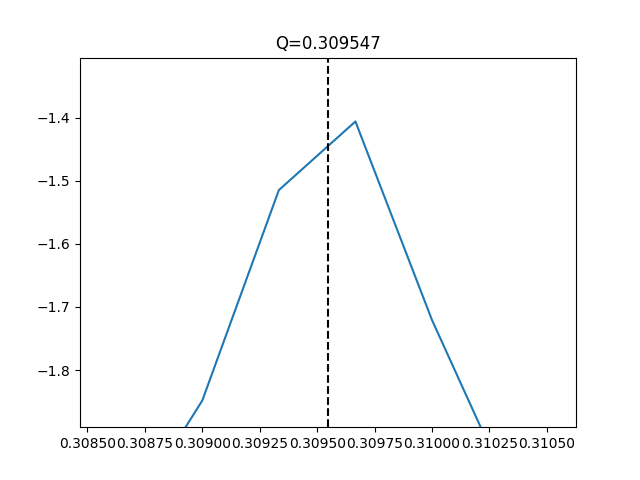

Text(0.5, 1.0, 'Q=0.309547')

In [82]:
%matplotlib notebook

from harmonic_analysis import HarmonicAnalysis

positions = x_optics3[0:3000]

harmon = HarmonicAnalysis(positions,zero_pad=True)
tunes,coefs = harmon.laskar_method(1)
tune = tunes[0]


fftFreqs = np.fft.fftshift(np.fft.fftfreq(len(positions)))
fftMag = np.log10(np.abs(np.fft.fftshift(np.fft.fft(positions))))
freqMask = np.logical_and(fftFreqs>0.2,fftFreqs<0.4)
fftFreqs = fftFreqs[freqMask]
fftMag = fftMag[freqMask]
plt.figure(1)
plt.plot(fftFreqs,fftMag)
plt.axvline(tune,color='k',ls='--')
plt.title("Q=%.6f"%tune)


# Simulations with white noise (only complete wake)

In [56]:
def py_ht_wake_sim_wn(n_macroparticles, n_slices, components_wake_input=None, add_wake=True, add_damper=True,
                   n_turns_wake=1, n_turns=5000):
    

    C = 26658.883
    R = C / (2.*np.pi)

    alpha_x = 0.
    alpha_y = 0.
    beta_x = 66.0064
    beta_y = 71.5376
    alpha_0 = [0.0003225]

    machine_configuration = 'LHC_6.5TeV_collision_2016'

    chroma = 0
    i_oct = 0

    machine = LHC(n_segments=1,
                  machine_configuration=machine_configuration,
                  **get_nonlinear_params(chroma=chroma, i_oct=i_oct))

    
    epsn_x = 3.e-6 # normalised horizontal emittance
    epsn_y = 3.e-6 # normalised vertical emittance
    sigma_z = 1.2e-9 * machine.beta*c/4. # RMS bunch length in meters
    intensity = 1.1e11

    bunch = machine.generate_6D_Gaussian_bunch_matched(
            n_macroparticles, intensity, epsn_x, epsn_y, sigma_z=sigma_z)

    slicer_for_wakefields = UniformChargeSlicer(
            n_slices, z_cuts=(-8*sigma_z, 8*sigma_z))

    wakefile = 'wakeforhdtl_PyZbase_Allthemachine_6800GeV_B1_2021_TeleIndex1_updatedMOs_updatedMo_on_MoC_wake'

    data_wake = np.genfromtxt(wakefile + '.dat')
    
    components_wake = ['time', 'dipole_x', 'dipole_y',
                       'quadrupole_x', 'quadrupole_y',
                       'dipole_xy', 'dipole_yx']
    
    if components_wake_input is None: 
        components_wake_input = components_wake.copy()
    
    inds_wake = []
    
    for i, comp_inp in enumerate(components_wake_input):
            for comp in components_wake:
                if comp_inp == comp:
                    inds_wake.append(i)
                
    print(inds_wake)
    
    data_wake = data_wake[:,inds_wake]
    components_wake = np.array(components_wake)[inds_wake]
    
    np.savetxt(wakefile+"_user.dat", data_wake, delimiter='\t', fmt='%15.10e' ,newline='\n')

    wake_table = WakeTable(wakefile+"_user.dat",
                            components_wake, n_turns_wake=n_turns_wake)

    os.system('rm '+wakefile+ '_user.dat')
    
    wake_field = WakeField(slicer_for_wakefields, wake_table)

    damping_rate = 1000 # in turns
    
    if add_damper:
        damper = TransverseDamper(damping_rate, damping_rate)
        machine.one_turn_map.append(damper)
    if add_wake:
        machine.one_turn_map.append(wake_field)

    # prepare empty arrays to record transverse moments
    x = np.zeros(n_turns)
    xp = np.zeros_like(x)
    y = np.zeros_like(x)
    yp = np.zeros_like(x)
    t = np.arange(n_turns)
    # actual tracking
    kick_x = np.random.random(size=n_turns)*5e-5 - 2.5e-5
    kick_y = np.random.random(size=n_turns)*5e-5 - 2.5e-5
    for i in tqdm(t):
        for m in machine.one_turn_map:
            bunch.xp += kick_x[i]/1000
            bunch.yp += kick_y[i]/1000
            m.track(bunch)
            x[i] = bunch.mean_x()
            xp[i] = bunch.mean_xp()
            y[i] = bunch.mean_y() 
            yp[i] = bunch.mean_yp()

    # evaluation of dipolar bunch moments
    j_x = np.sqrt(x**2 + (beta_x * xp)**2)
    exponent_x, amplitude_x = np.polyfit(t, np.log(2 * j_x), 1)

    j_y = np.sqrt(y**2 + (beta_y * yp)**2)
    exponent_y, amplitude_y = np.polyfit(t, np.log(2 * j_y), 1)

    print ('Horizontal reconstructed damping time: {:.3f} turns'.format(1/exponent_x))
    print ('Vertical reconstructed damping time: {:.3f} turns'.format(1/exponent_y))

    return x, y, xp, yp, machine, kick_x, kick_y

In [59]:
# Basic parameters.
n_sl = 500
n_mps = 1000000

x_dip_wake_wn, y_dip_wake_wn, xp_dip_wake_wn, yp_dip_wake_wn, machine, kick_x, kick_y = py_ht_wake_sim_wn(n_mps, n_sl, add_damper=False, add_wake=False, 
                                                            #components_wake_input=['time', 'dipole_x', 'dipole_y'], 
                                                            n_turns=5000)


Synchrotron init. From kwargs: app_x = 0.0
Synchrotron init. From kwargs: app_y = 0.0
Synchrotron init. From kwargs: app_xy = -0.0
Synchrotron init. From kwargs: Qp_x = [0 ...]
Synchrotron init. From kwargs: Qp_y = [0 ...]
*** Maximum RMS bunch length 0.11789515101464539m.
... distance to target bunch length: -8.9938e-02
... distance to target bunch length: 2.4700e-02
... distance to target bunch length: 2.2562e-02
... distance to target bunch length: 4.1287e-03
... distance to target bunch length: -8.3050e-03
... distance to target bunch length: 6.8811e-04
... distance to target bunch length: -1.6257e-05
... distance to target bunch length: 2.5724e-07
... distance to target bunch length: -3.3327e-08
--> Bunch length: 0.08993770313589648
--> Emittance: 2.3327935372128716
[0, 1, 2, 3, 4, 5, 6]
dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
dipole_xy Assuming ultrarelativistic wake.
dipole_yx Assuming ultrarelativistic wake.
quadrupole_x Assuming ultr

100%|██████████████████████| 5000/5000 [08:25<00:00,  9.89it/s]

Horizontal reconstructed damping time: 14137.899 turns
Vertical reconstructed damping time: 3372.612 turns


In [60]:
Qx, Qy = compute_tune_windows(x_dip_wake_wn, xp_dip_wake_wn, y_dip_wake_wn, yp_dip_wake_wn, machine, n_turns_max=5000, Q_window_size = 400, window_staggering = 50)

Horizontal fractional tune: 0.310 vs. reconstructed 0.310
Vertical fractional tune: 0.320 vs. reconstructed 0.320


In [61]:
import scipy.io as sio

dict_dip_wake_wn = {
    'x': x_dip_wake_wn,
    'y': y_dip_wake_wn,
    'xp': xp_dip_wake_wn,
    'yp': yp_dip_wake_wn,
    'Qx': Qx,
    'Qy': Qy
}


sio.savemat('res_dip_wake_wn.mat', dict_dip_wake_wn)

<IPython.core.display.Javascript object>


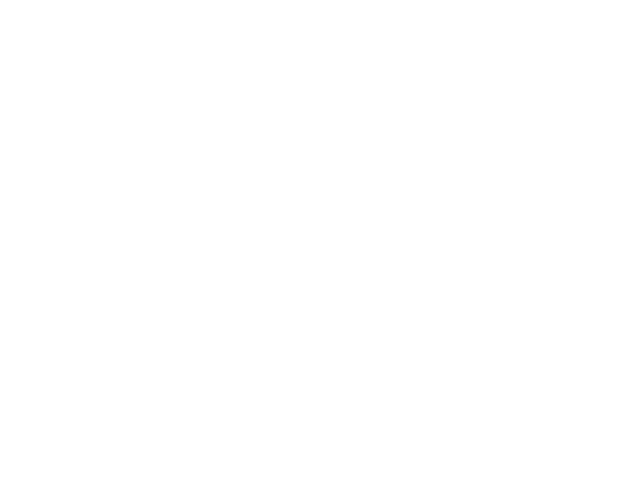

<IPython.core.display.Javascript object>


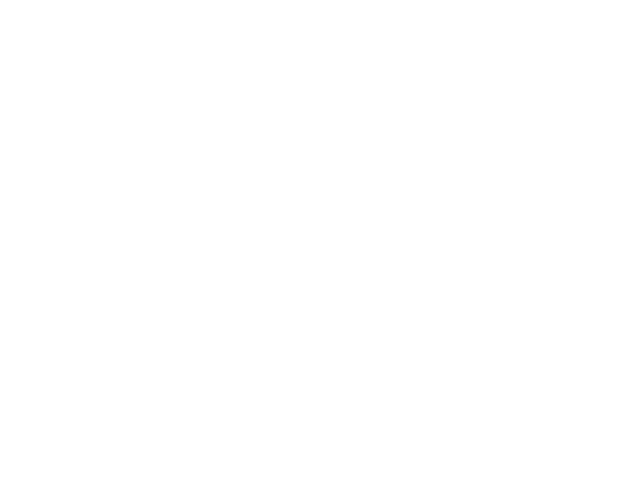

In [19]:
dict_dip_wake_wn = sio.loadmat('res_dip_wake_wn.mat', squeeze_me=True)

x_dip_wake_wn = dict_dip_wake_wn['x']
y_dip_wake_wn = dict_dip_wake_wn['y']
Qx_dip_wake_wn = dict_dip_wake_wn['Qx']
Qy_dip_wake_wn = dict_dip_wake_wn['Qy']

plot_beam_position(x_dip_wake_wn, y_dip_wake_wn)
plot_tune_windows(Qx_dip_wake_wn, Qy_dip_wake_wn, machine.Q_x, machine.Q_y)